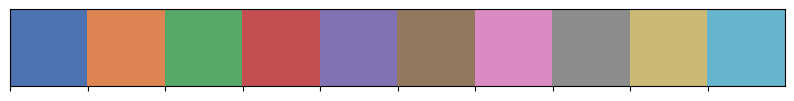

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2]
datadir = 'benchmarks_2023May01'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = {}

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [3]:
results = torch.load(os.path.join(datadir, "summarized_results.pt"))
print(results.keys())
print(results[(0.1,0.5)].keys())

dict_keys([(0.1, 0.5), (0.1, 1.0), (0.1, 2.0), (0.2, 0.5), (0.2, 1.0), (0.2, 2.0)])
dict_keys(['mean_loss_avg_over_runs_samples', 'std_loss_avg_over_runs_samples', 'loss_avg_over_runs', 'loss_full', 'loss_indices', 'param_true', 'times', 'signals', 'measured_settings', 'measured_values', 'times_finer', 'signals_finer'])


In [4]:
results[(0.1,0.5)]['loss_avg_over_runs'].mean(dim=1)[:,-1,:2]

tensor([[0.1208, 0.0682],
        [0.1672, 0.1002],
        [0.1700, 0.0954],
        [0.2877, 0.1638]])

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
gamma = 0.1
pulse_width = 0.1
noise_level = 0.5
times = np.linspace(0, 3, 121)

In [7]:
def compute_gradient(value, step):
    grad = torch.zeros_like(value)
    grad[...,1:-1] = (value[...,2:] - value[...,:-2]) / (2 * step)
    grad[...,0] = (value[...,1] - value[...,0]) / step
    grad[...,-1] = (value[...,-1] - value[...,-2]) / step
    return grad

In [8]:
_result = results[(pulse_width, noise_level)]
step = (_result['times'][1] - _result['times'][0]).item()
step_finer = (_result['times_finer'][1] - _result['times_finer'][0]).item()

In [9]:
grad = compute_gradient(_result['signals'], step)
grad_finer = compute_gradient(_result['signals_finer'], step_finer)
abs_grad = np.zeros((20,100))

In [10]:
measured_abs_grad_dict = {}
for key in results.keys():
    # print(key)
    _result = results[key]
    grad = compute_gradient(_result['signals'], step)
    abs_grad = np.zeros((20,100))
    for i_strat in range(20):
        for j_sample in range(100):
            indices = np.round(_result['measured_settings'][i_strat][j_sample] / step).astype('int')
            abs_grad[i_strat,j_sample] = grad[i_strat,j_sample,indices].abs().mean().item()
    measured_abs_grad = torch_scatter.scatter_mean(torch.from_numpy(abs_grad), scatter_mean_indices, dim=0)
    measured_abs_grad_dict[key] = measured_abs_grad

In [11]:
for key in results.keys():
    print(key, measured_abs_grad_dict[key].mean(dim=-1))

(0.1, 0.5) tensor([181.8866, 187.9052, 136.7766, 136.5772], dtype=torch.float64)
(0.1, 1.0) tensor([185.9300, 191.1834, 134.6760, 135.7248], dtype=torch.float64)
(0.1, 2.0) tensor([191.4481, 197.3720, 136.9593, 137.3186], dtype=torch.float64)
(0.2, 0.5) tensor([126.3323, 130.4020, 103.9607, 108.7633], dtype=torch.float64)
(0.2, 1.0) tensor([128.8043, 134.8261, 109.2894, 108.2679], dtype=torch.float64)
(0.2, 2.0) tensor([133.2390, 139.9730, 106.3862, 107.2732], dtype=torch.float64)


Text(0.02, 0.5, '$|\\partial s(t)/\\partial t|$')

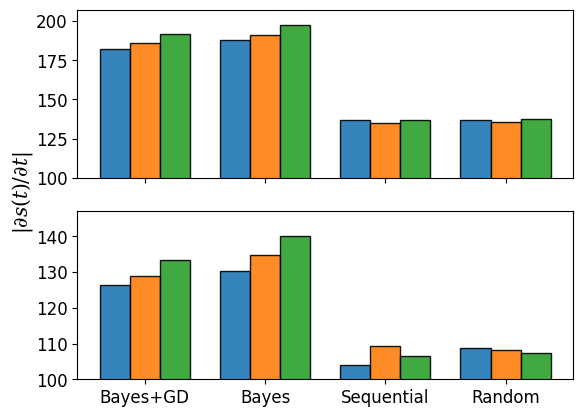

In [12]:
fig, axes = plt.subplots(2,1,sharex=True)

ax1 = axes[0]
ax2 = axes[1]
bar_width = 0.25
for i_key, _key in enumerate([(0.1, 0.5),(0.1, 1.0),(0.1, 2.0)]):
    ax1.bar(np.arange(4)+bar_width*(i_key-1), measured_abs_grad_dict[_key].mean(dim=-1), width=bar_width, edgecolor='k', alpha=0.9)
ax1.set_ylim([100,None])

for i_key, _key in enumerate([(0.2, 0.5),(0.2, 1.0),(0.2, 2.0)]):
    ax2.bar(np.arange(4)+bar_width*(i_key-1), measured_abs_grad_dict[_key].mean(dim=-1), width=bar_width, edgecolor='k', alpha=0.9)
ax2.set_ylim([100,None])
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'])
fig.supylabel(r'$|\partial s(t)/\partial t|$')

In [13]:
key=(0.1, 1.0)

Text(0.5, 1.0, '$w=0.1$ ps, $\\sigma=1.0$')

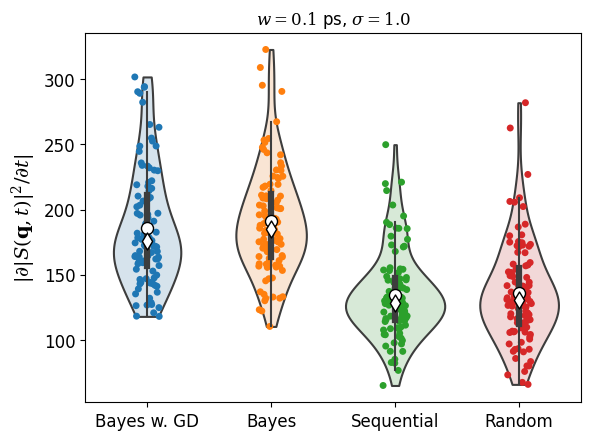

In [14]:
from matplotlib.colors import to_rgba
ylabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(1,1)
sns.violinplot([m.numpy() for m in measured_abs_grad_dict[key]], ax=ax, zorder=10, inner='box', cut=0)
for vp in ax.collections[::2]:
    vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
sns.stripplot([m.numpy() for m in measured_abs_grad_dict[key]], ax=ax, zorder=1)
ax.scatter(np.arange(4), [np.median(m.numpy()) for m in measured_abs_grad_dict[key]], 
           zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
ax.scatter(np.arange(4), [np.mean(m.numpy()) for m in measured_abs_grad_dict[key]], 
           zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
ax.set_xticklabels(['Bayes w. GD', 'Bayes', 'Sequential', 'Random'])
# ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
ax.set_ylabel("$|\partial |S(\mathbf{q},t)|^{2}/\partial t|$")
# # ax.legend(ncols=2)
ax.set_xlim([-0.5, 3.5])
ax.set_title(f"$w={key[0]}$ ps, $\sigma={key[1]}$")

In [15]:
key=(0.1, 0.5)

Text(0, 0.5, '$|\\partial s(t)\\ / \\ \\partial t|$')

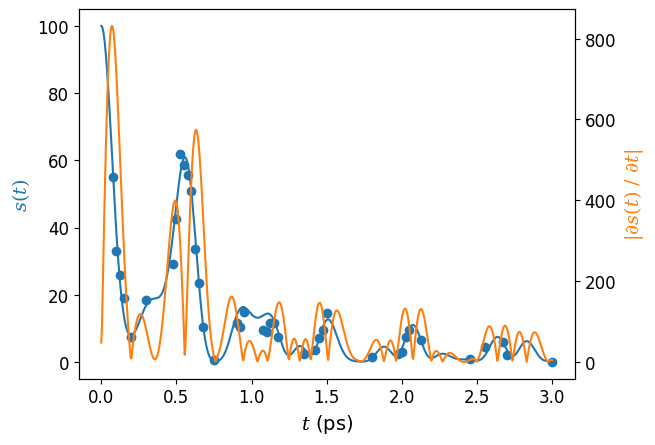

In [16]:
i_strat = 0
j_sample = 11
_result = results[key]

fig, ax = plt.subplots(1, 1)
ax_twin = ax.twinx()
ax.plot(_result['times_finer'], _result['signals_finer'][i_strat,j_sample])
ax_twin.plot(_result['times_finer'], np.abs(grad_finer[i_strat,j_sample]), color='C1')
# ax_twin.plot(_result['times_finer'], (grad_finer[i_strat,j_sample]), color='C1')
ax.scatter(_result['measured_settings'][i_strat][j_sample], _result['measured_values'][i_strat][j_sample])
ax.set_xlabel("$t$ (ps)")
ax.set_ylabel("$s(t)$", color='C0')
ax_twin.set_ylabel("$|\partial s(t)\ / \ \partial t|$", color='C1')

In [17]:
measured_abs_grad_dict_all_keys = None
for key in results.keys():
    print(key)
    if measured_abs_grad_dict_all_keys is None:
        measured_abs_grad_dict_all_keys = torch.zeros_like(measured_abs_grad_dict[key])
    else:
        measured_abs_grad_dict_all_keys += measured_abs_grad_dict[key]

measured_abs_grad_dict_all_keys = measured_abs_grad_dict_all_keys.numpy() / len(results.keys())

(0.1, 0.5)
(0.1, 1.0)
(0.1, 2.0)
(0.2, 0.5)
(0.2, 1.0)
(0.2, 2.0)


(-0.5, 3.5)

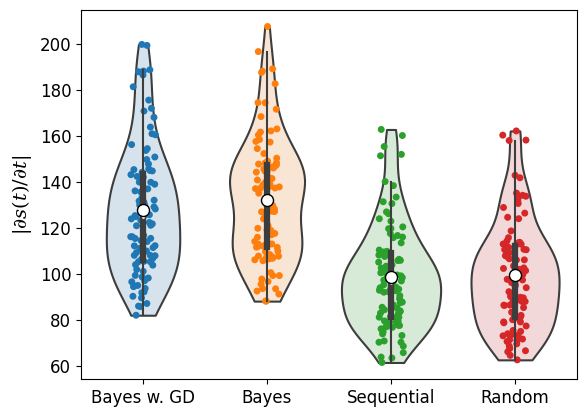

In [18]:
from matplotlib.colors import to_rgba
ylabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(1,1)
sns.violinplot([m for m in measured_abs_grad_dict_all_keys], ax=ax, zorder=10, inner='box', cut=0)
for vp in ax.collections[::2]:
    vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
sns.stripplot([m for m in measured_abs_grad_dict_all_keys], ax=ax, zorder=1)
# ax.scatter(np.arange(4), [np.median(m) for m in measured_abs_grad_dict_all_keys], 
#            zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
ax.scatter(np.arange(4), [np.mean(m) for m in measured_abs_grad_dict_all_keys], 
           zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
ax.set_xticklabels(['Bayes w. GD', 'Bayes', 'Sequential', 'Random'])
# ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
# ax.set_ylabel("$|\partial |S(\mathbf{q},t)|^{2}/\partial t|$")
ax.set_ylabel("$|\partial s(t)/\partial t|$")
# # ax.legend(ncols=2)
ax.set_xlim([-0.5, 3.5])
# ax.set_title(f"$w={key[0]}$ ps, $\sigma={key[1]}$")

In [19]:
from matplotlib.colors import to_rgba

loss_avg_over_runs_all = None
for key in results.keys():
    if loss_avg_over_runs_all is None:
        loss_avg_over_runs_all = results[key]['loss_avg_over_runs'].clone()
    else:
        loss_avg_over_runs_all += results[key]['loss_avg_over_runs']

loss_avg_over_runs_all /= len(results.keys())


In [20]:
results[(0.1,0.5)]['loss_avg_over_runs'].mean(dim=1)[:,-1,:2]

tensor([[0.1208, 0.0682],
        [0.1672, 0.1002],
        [0.1700, 0.0954],
        [0.2877, 0.1638]])

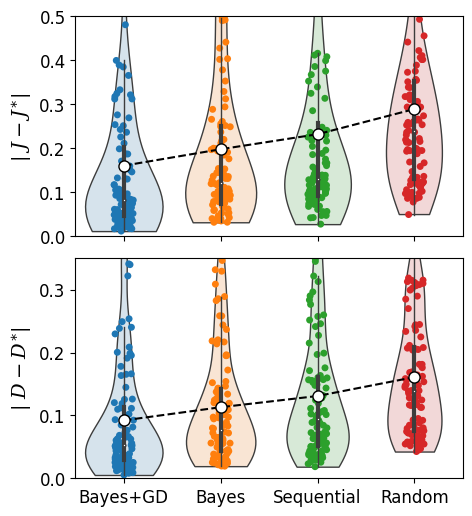

In [21]:

fig, axes = plt.subplots(
    2, 1, figsize=(5,6),
    sharex=True, gridspec_kw={'hspace': 0.1})

for i_param in [0,1]:
    ax = axes[i_param]
    sns.violinplot([loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=10, inner='box', cut=0, linewidth=1)
    for vp in ax.collections[::2]:
        vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
    sns.stripplot([loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=1)
    # ax.scatter(np.arange(4), [np.median(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
    #         zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
    # ax.plot(np.arange(4), [np.median(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 'k-d',
    #         zorder=25, markersize=10, markeredgecolor='k', markerfacecolor='w', label='Median')
    ax.plot(np.arange(4), [np.mean(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 'k--o',
            zorder=25, markersize=8, markeredgecolor='k', markerfacecolor='w', label='Mean')
    # ax.scatter(np.arange(4), [np.mean(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
    #         zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
    ax.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'])
    ax.set_ylabel(rf'$|\ {ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
    # ax.legend(ncols=2)
    ax.set_xlim([-0.5, 3.5])    
    if i_param == 0:
        ax.set_ylim([0., 0.5])
    else:
        ax.set_ylim([0., 0.35])

In [22]:
results[key]['loss_avg_over_runs'].shape

torch.Size([4, 100, 41, 5])

[Text(0, 0, 'Bayes+GD'),
 Text(1, 0, 'Bayes'),
 Text(2, 0, 'Sequential'),
 Text(3, 0, 'Random')]

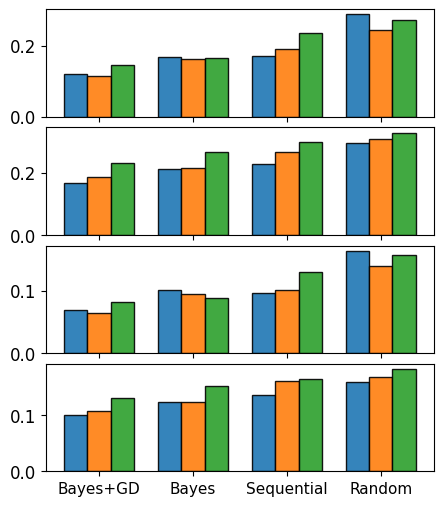

In [23]:

fig, axes = plt.subplots(
    4, 1, figsize=(5,6),
    sharex=True, gridspec_kw={'hspace': 0.1})
ax_J1 = axes[0]
ax_J2 = axes[1]
ax_D1 = axes[2]
ax_D2 = axes[3]

bar_width=0.25
for i_key, key in enumerate([(0.1,0.5), (0.1,1.0), (0.1,2.0)]):
    ax_J1.bar(np.arange(4)+bar_width*(i_key-1), results[key]['loss_avg_over_runs'][:,:,-1,0].mean(axis=1), width=bar_width, edgecolor='k', alpha=0.9)
    ax_D1.bar(np.arange(4)+bar_width*(i_key-1), results[key]['loss_avg_over_runs'][:,:,-1,1].mean(axis=1), width=bar_width, edgecolor='k', alpha=0.9)

for i_key, key in enumerate([(0.2,0.5), (0.2,1.0), (0.2,2.0)]):
    ax_J2.bar(np.arange(4)+bar_width*(i_key-1), results[key]['loss_avg_over_runs'][:,:,-1,0].mean(axis=1), width=bar_width, edgecolor='k', alpha=0.9)
    ax_D2.bar(np.arange(4)+bar_width*(i_key-1), results[key]['loss_avg_over_runs'][:,:,-1,1].mean(axis=1), width=bar_width, edgecolor='k', alpha=0.9)

ax_D2.set_xticks(np.arange(4))
ax_D2.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'], fontsize=11)
# for i_param in [0,1]:
#     ax = axes[i_param]
#     ax.plot(np.arange(4), [np.mean(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 'k--o',
#             zorder=25, markersize=8, markeredgecolor='k', markerfacecolor='w', label='Mean')
    
#     ax.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'])
#     ax.set_ylabel(rf'$|\ {ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
#     # ax.legend(ncols=2)
#     ax.set_xlim([-0.5, 3.5])    
#     if i_param == 0:
#         ax.set_ylim([0., 0.5])
#     else:
#         ax.set_ylim([0., 0.35])

In [24]:
from sklearn.neighbors import KernelDensity

In [25]:

key_plot = (0.2, 1.0)

J_kde_grid = np.linspace(0,1,201)[:,None]
D_kde_grid = np.linspace(0,1,201)[:,None]

J_kde_list = [KernelDensity(kernel='cosine', bandwidth=0.075).fit(results[key_plot]['loss_avg_over_runs'][i_strat,:,-1,0].numpy()[:,None]) for i_strat in range(4)]
D_kde_list = [KernelDensity(kernel='cosine', bandwidth=0.075).fit(results[key_plot]['loss_avg_over_runs'][i_strat,:,-1,1].numpy()[:,None]) for i_strat in range(4)]

J_dens_list = [np.exp(_kde.score_samples(J_kde_grid)) for _kde in J_kde_list]
D_dens_list = [np.exp(_kde.score_samples(J_kde_grid)) for _kde in D_kde_list]

C:\Users\zhant\AppData\Local\Temp\ipykernel_21392\3172525848.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  ax1.plot(results[key_plot]['mean_loss_avg_over_runs_samples'][i,:,0].T, linestyle=linestyles[i], label=legends[i])


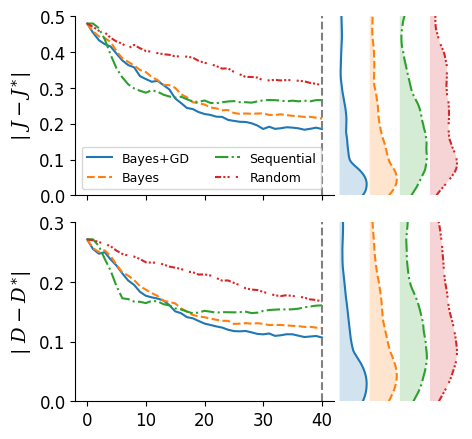

In [26]:
linestyles = ['-', '--', '-.', (0,(3,1,1,1,1))]
legends = ['Bayes+GD', 'Bayes', 'Sequential', 'Random']


fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0., hspace=0.15, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xticklabels([])
ax2 = fig.add_subplot(gs[1,0])
ax2.spines[['right', 'top']].set_visible(False)
ax1_histy = fig.add_subplot(gs[0, 1], sharey=ax1)
ax1_histy.axis('off')
ax1_histy.set_ylim([0, 0.5])
ax2_histy = fig.add_subplot(gs[1, 1], sharey=ax2, sharex=ax1_histy)
ax2_histy.set_ylim([0, 0.3])
ax2_histy.axis('off')


for i in range(4):
    ax1.plot(results[key_plot]['mean_loss_avg_over_runs_samples'][i,:,0].T, linestyle=linestyles[i], label=legends[i])
    ax1_histy.plot(i+0.9*J_dens_list[i] / J_dens_list[i].max(), J_kde_grid.squeeze(), linestyle=linestyles[i])
    ax1_histy.fill_betweenx(J_kde_grid.squeeze(), i+0.9*J_dens_list[i] / J_dens_list[i].max(), i*np.ones_like(J_kde_grid.squeeze()), alpha=0.2)
    ax2.plot(results[key_plot]['mean_loss_avg_over_runs_samples'][i,:,1].T, linestyle=linestyles[i], label=legends[i])
    ax2_histy.plot(i+0.9*D_dens_list[i] / D_dens_list[i].max(), D_kde_grid.squeeze(), linestyle=linestyles[i])
    ax2_histy.fill_betweenx(D_kde_grid.squeeze(), i+0.9*D_dens_list[i] / D_dens_list[i].max(), i*np.ones_like(D_kde_grid.squeeze()), alpha=0.2)
    ax1.legend(ncols=2, fontsize=9)
    # ax1_histy.text(i+0.15, 0.25, legends[i], rotation=90)
ax1.vlines(40, 0, 1, linestyles='--', color='gray')
ax2.vlines(40, 0, 1, linestyles='--', color='gray')

ax1.set_ylabel(r'$|\ J-J^{\ast}|$')
ax2.set_ylabel(r'$|\ D-D^{\ast}|$')
fig.align_ylabels([ax1, ax2])
# i_param = 0
# sns.violinplot([results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,i_param].numpy() for i_strat in range(4)], 
#                ax=ax1_histy, zorder=10, inner='box', cut=0, linewidth=1)
# for vp in ax1_histy.collections[::2]:
#     vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.5))
# sns.stripplot([results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax1_histy, zorder=1)
# ax1_histy.scatter(np.arange(4), [np.mean(results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
#            zorder=20, edgecolors='k', facecolors='w', marker='o', s=50, label='Mean')

# i_param = 1
# sns.violinplot([results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,i_param].numpy() for i_strat in range(4)], 
#                ax=ax2_histy, zorder=10, inner='box', cut=0, linewidth=1)
# for vp in ax2_histy.collections[::2]:
#     vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.5))
# sns.stripplot([results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax1_histy, zorder=1)
# ax2_histy.scatter(np.arange(4), [np.mean(results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
#            zorder=20, edgecolors='k', facecolors='w', marker='o', s=50, label='Mean')


C:\Users\zhant\AppData\Local\Temp\ipykernel_21392\452215396.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


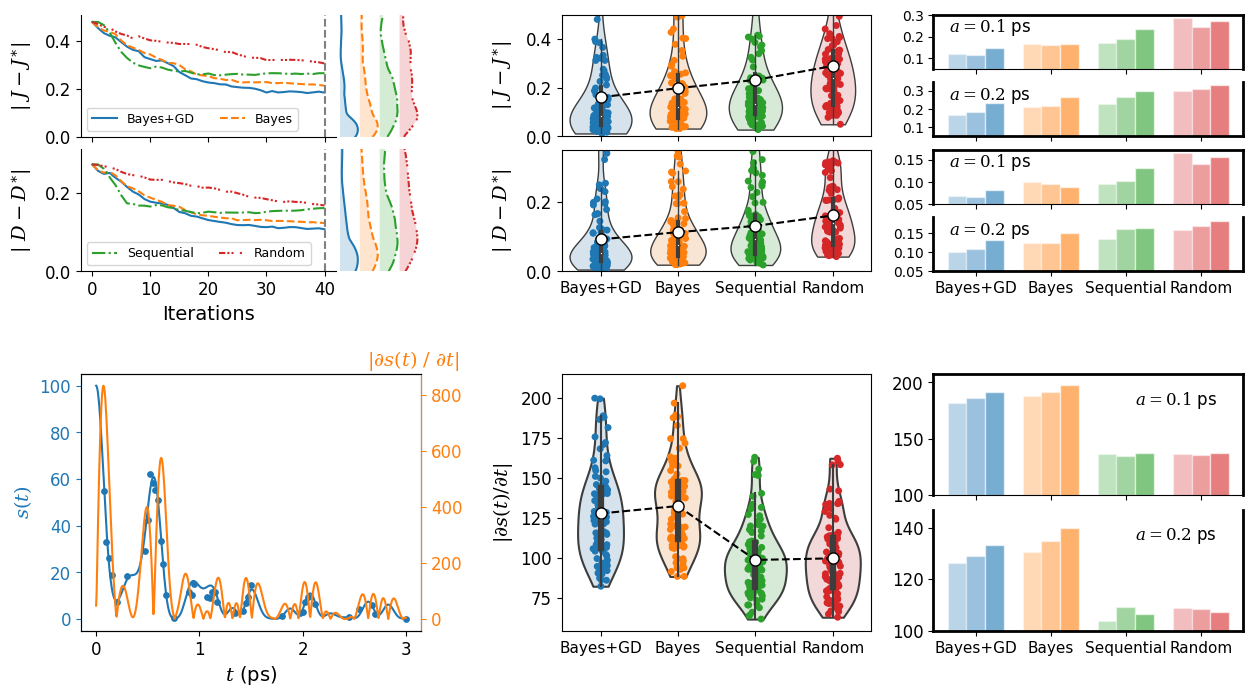

In [127]:
import matplotlib.ticker as plticker

xloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
yloc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals

fig = plt.figure(figsize=(15,8), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.275, hspace=0.4, width_ratios=[1,2])

gs_loss_kde = gs[0,0].subgridspec(nrows=2, ncols=2, wspace=0., hspace=0.1, width_ratios=[3,1])
ax1 = fig.add_subplot(gs_loss_kde[0,0])
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xticklabels([])
ax2 = fig.add_subplot(gs_loss_kde[1,0])
ax2.spines[['right', 'top']].set_visible(False)
ax1_histy = fig.add_subplot(gs_loss_kde[0, 1], sharey=ax1)
ax1_histy.axis('off')
ax1_histy.set_ylim([0.0, 0.51])
ax2_histy = fig.add_subplot(gs_loss_kde[1, 1], sharey=ax2, sharex=ax1_histy)
ax2_histy.set_ylim([0.0, 0.31])
ax2_histy.axis('off')

for i in range(4):
    ax1.plot(results[key_plot]['mean_loss_avg_over_runs_samples'][i,:,0].T, linestyle=linestyles[i], label=legends[i] if i < 2 else '_nolegend_')
    ax1_histy.plot(i+0.9*J_dens_list[i] / J_dens_list[i].max(), J_kde_grid.squeeze(), linestyle=linestyles[i])
    ax1_histy.fill_betweenx(J_kde_grid.squeeze(), i+0.9*J_dens_list[i] / J_dens_list[i].max(), i*np.ones_like(J_kde_grid.squeeze()), alpha=0.2)
    ax2.plot(results[key_plot]['mean_loss_avg_over_runs_samples'][i,:,1].T, linestyle=linestyles[i], label=legends[i] if i >= 2 else '_nolegend_')
    ax2_histy.plot(i+0.9*D_dens_list[i] / D_dens_list[i].max(), D_kde_grid.squeeze(), linestyle=linestyles[i])
    ax2_histy.fill_betweenx(D_kde_grid.squeeze(), i+0.9*D_dens_list[i] / D_dens_list[i].max(), i*np.ones_like(D_kde_grid.squeeze()), alpha=0.2)
ax1.legend(ncols=2, fontsize=9)
ax2.legend(ncols=2, fontsize=9)
ax1.vlines(40, 0, 1, linestyles='--', color='gray')
ax1.set_ylabel(rf'$|\ J-J^{{\ast}}|$', fontsize=14)
ax2.vlines(40, 0, 1, linestyles='--', color='gray')
ax2.set_ylabel(rf'$|\ D-D^{{\ast}}|$', fontsize=14)
ax2.set_xlabel('Iterations', fontsize=14)

ax_gd = fig.add_subplot(gs[1,0])
ax_twin = ax_gd.twinx()
ax_gd.plot(_result['times_finer'], _result['signals_finer'][i_strat,j_sample])
ax_twin.plot(_result['times_finer'], np.abs(grad_finer[i_strat,j_sample]), color='C1')
ax_gd.scatter(_result['measured_settings'][i_strat][j_sample], _result['measured_values'][i_strat][j_sample], s=15)
ax_gd.set_xlabel("$t$ (ps)", fontsize=14)
ax_gd.set_ylabel("$s(t)$", color='C0', fontsize=14)
ax_twin.set_ylabel("$|\partial s(t)\ / \ \partial t|$", color='C1', fontsize=14, rotation=0)
ax_gd.spines['left'].set_color('C0')
ax_gd.yaxis.label.set_color('C0')
ax_gd.tick_params(axis='y', colors='C0')
ax_twin.yaxis.set_label_coords(0.975,1.1)
ax_twin.spines['right'].set_color('C1')
ax_twin.yaxis.label.set_color('C1')
ax_twin.tick_params(axis='y', colors='C1')
fig.align_ylabels([ax1,ax2,ax_gd])


gs_loss_summary = gs[0,1].subgridspec(nrows=4, ncols=2, hspace=0.25)

for i_param in [0,1]:
    ax = fig.add_subplot(gs_loss_summary[2*i_param:2*(i_param+1),0])
    sns.violinplot([loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=10, inner='box', cut=0, linewidth=1)
    for vp in ax.collections[::2]:
        vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
    sns.stripplot([loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=1)
    ax.plot(np.arange(4), [np.mean(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 'k--o',
            zorder=25, markersize=8, markeredgecolor='k', markerfacecolor='w', label='Mean')
    ax.set_xticklabels([])
    if i_param == 1:
        ax.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'], fontsize=11)
    ax.set_ylabel(rf'$|\ {ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$', fontsize=14)
    ax.set_xlim([-0.5, 3.5])
    if i_param == 0:
        ax.set_ylim([0., 0.5])
        yloc = plticker.MultipleLocator(base=0.15) # this locator puts ticks at regular intervals
        ax_loss_1 = ax
    else:
        ax.set_ylim([0., 0.35])
        yloc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
        # ax.yaxis.set_major_locator(yloc)
        ax_loss_2 = ax
    
    # if i_param == 1:
        # ax.spines[['top']].set_visible(False)

# gs_loss_barplt = gs[0,2].subgridspec(nrows=4, ncols=1, hspace=0.2)
ax_bar_J1 = fig.add_subplot(gs_loss_summary[0,1])
plt.setp(ax_bar_J1.get_xticklabels(), visible=False)
ax_bar_J2 = fig.add_subplot(gs_loss_summary[1,1], sharex=ax_bar_J1)
plt.setp(ax_bar_J2.get_xticklabels(), visible=False)
ax_bar_D1 = fig.add_subplot(gs_loss_summary[2,1], sharex=ax_bar_J1)
plt.setp(ax_bar_D1.get_xticklabels(), visible=False)
ax_bar_D2 = fig.add_subplot(gs_loss_summary[3,1], sharex=ax_bar_J1)
bar_width=0.25
for i_key, _key in enumerate([(0.1,0.5), (0.1,1.0), (0.1,2.0)]):
    ax_bar_J1.bar(np.arange(4)+bar_width*(i_key-1), results[_key]['loss_avg_over_runs'][:,:,-1,0].mean(axis=1), width=bar_width, edgecolor='w', alpha=0.3+0.15*i_key, color=['C0','C1','C2','C3'])
    ax_bar_D1.bar(np.arange(4)+bar_width*(i_key-1), results[_key]['loss_avg_over_runs'][:,:,-1,1].mean(axis=1), width=bar_width, edgecolor='w', alpha=0.3+0.15*i_key, color=['C0','C1','C2','C3'])
ax_bar_J2.spines[['top']].set_visible(False)
ax_bar_J1.text(.05, .68, '$a=0.1$ ps', transform=ax_bar_J1.transAxes)
ax_bar_J2.text(.05, .68, '$a=0.2$ ps', transform=ax_bar_J2.transAxes)
ax_bar_J1.spines[['left', 'right', 'top']].set_linewidth(2.0)
ax_bar_J2.spines[['left', 'right', 'bottom']].set_linewidth(2.0)

for i_key, _key in enumerate([(0.2,0.5), (0.2,1.0), (0.2,2.0)]):
    ax_bar_J2.bar(np.arange(4)+bar_width*(i_key-1), results[_key]['loss_avg_over_runs'][:,:,-1,0].mean(axis=1), width=bar_width, edgecolor='w', alpha=0.3+0.15*i_key, color=['C0','C1','C2','C3'])
    ax_bar_D2.bar(np.arange(4)+bar_width*(i_key-1), results[_key]['loss_avg_over_runs'][:,:,-1,1].mean(axis=1), width=bar_width, edgecolor='w', alpha=0.3+0.15*i_key, color=['C0','C1','C2','C3'])
ax_bar_D2.set_xticks(np.arange(4))
ax_bar_D1.text(.05, .68, '$a=0.1$ ps', transform=ax_bar_D1.transAxes)
ax_bar_D2.text(.05, .68, '$a=0.2$ ps', transform=ax_bar_D2.transAxes)
ax_bar_D2.spines[['top']].set_visible(False)
ax_bar_D1.spines[['left', 'right', 'top']].set_linewidth(2.0)
ax_bar_D2.spines[['left', 'right', 'bottom']].set_linewidth(2.0)
ax_bar_D2.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'], fontsize=11)

for _ax in [ax_bar_J1, ax_bar_J2, ax_bar_D1, ax_bar_D2]:
    _ax.set_ylim([0.05,None])
    _ax.tick_params(axis='y', labelsize=10)

gs_dsdt_summary = gs[1,1].subgridspec(nrows=2, ncols=2, hspace=0.12)

ax_dsdt = fig.add_subplot(gs_dsdt_summary[:,0])
sns.violinplot([m for m in measured_abs_grad_dict_all_keys], ax=ax_dsdt, zorder=10, inner='box', cut=0)
for vp in ax_dsdt.collections[::2]:
    vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
sns.stripplot([m for m in measured_abs_grad_dict_all_keys], ax=ax_dsdt, zorder=1)
ax_dsdt.plot(np.arange(4), [np.mean(m) for m in measured_abs_grad_dict_all_keys], 'k--o',
            zorder=25, markersize=8, markeredgecolor='k', markerfacecolor='w', label='Mean')
ax_dsdt.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'], fontsize=11)
ax_dsdt.set_ylabel("$|\partial s(t)/\partial t|$", fontsize=14)
ax_dsdt.set_xlim([-0.5, 3.5])

# gs_dsdt_barplt = gs[1,2].subgridspec(nrows=2, ncols=1, hspace=0.1)
ax_dsdt1 = fig.add_subplot(gs_dsdt_summary[0,1])
ax_dsdt2 = fig.add_subplot(gs_dsdt_summary[1,1])
bar_width = 0.25
for i_key, _key in enumerate([(0.1, 0.5),(0.1, 1.0),(0.1, 2.0)]):
    ax_dsdt1.bar(np.arange(4)+bar_width*(i_key-1), measured_abs_grad_dict[_key].mean(dim=-1), width=bar_width, edgecolor='w', alpha=0.3+0.15*i_key, color=['C0','C1','C2','C3'])
ax_dsdt1.set_ylim([100,None])
ax_dsdt1.text(.65, .75, '$a=0.1$ ps', transform=ax_dsdt1.transAxes)
plt.setp(ax_dsdt1.get_xticklabels(), visible=False)

for i_key, _key in enumerate([(0.2, 0.5),(0.2, 1.0),(0.2, 2.0)]):
    ax_dsdt2.bar(np.arange(4)+bar_width*(i_key-1), measured_abs_grad_dict[_key].mean(dim=-1), width=bar_width, edgecolor='w', alpha=0.3+0.15*i_key, color=['C0','C1','C2','C3'])
ax_dsdt2.spines[['top']].set_visible(False)
ax_dsdt1.spines[['left', 'right', 'top']].set_linewidth(2.0)
ax_dsdt2.spines[['left', 'right', 'bottom']].set_linewidth(2.0)
ax_dsdt2.set_ylim([100,None])
ax_dsdt2.set_xticks(np.arange(4))
ax_dsdt2.set_xticklabels(['Bayes+GD', 'Bayes', 'Sequential', 'Random'], fontsize=11)
ax_dsdt2.text(.65, .75, '$a=0.2$ ps', transform=ax_dsdt2.transAxes)

fig.align_ylabels([ax1, ax2, ax_gd])
fig.align_ylabels([ax_loss_1, ax_loss_2, ax_dsdt])

fig.tight_layout()
fig.savefig('figures/benchmarks/benchmark_summary.pdf', bbox_inches='tight')